## MNIST classification NN

In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch.utils.data import DataLoader
torch.__version__

'2.9.1'

In [2]:
PLOT_COLOR_NEUTRAL = '#344c63'
PLOT_COLOR_GOOD = '#62cc7e'
PLOT_COLOR_BAD = '#cf4d46' 


In [3]:
dataset_train = datasets.MNIST("data", download=True, train=True, transform=transforms.ToTensor())
dataset_test = datasets.MNIST("data", download=True, train=False, transform=transforms.ToTensor())

x_train, y_train = dataset_train.data.to(dtype=torch.float), dataset_train.targets
x_test, y_test = dataset_test.data.to(dtype=torch.float), dataset_test.targets

softmax = nn.Softmax(dim=0)
relu = nn.ReLU()

plt.rcParams['image.cmap'] = 'gray'

6


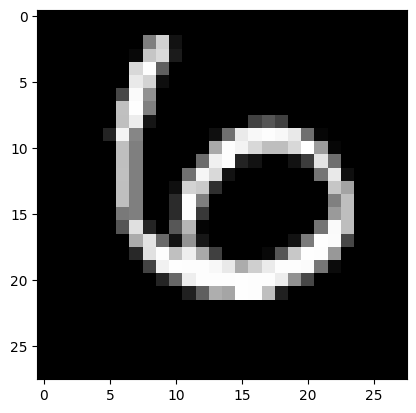

In [4]:
n = random.randint(0, len(x_train))
print(y_train[n].item())
plt.imshow(x_train[n])

In [5]:
x_train[0].shape

torch.Size([28, 28])

In [6]:
class MNISTClassifier(torch.nn.Module):
    def __init__(self, channels=8, kernel_size=5, stride=1, pool_size=2, pool_stride=2):
        super(MNISTClassifier, self).__init__()
        self.in_channels = 1  # MNIST pictures are grayscale 
        self.flatten = nn.Flatten()

        self.pipeline = torch.nn.Sequential(
            nn.Conv2d(1, 8, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(8, 16, 5, 1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(3, 3),
            nn.Flatten(),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.pipeline(x)

In [7]:
classifier = MNISTClassifier()

[4.004077345598489e-05, 0.039597924798727036, 3.7011747622273106e-07, 0.9347347617149353, 0.002002567984163761, 2.0240083813405363e-06, 0.0005911054904572666, 0.0003687556309159845, 0.022660817950963974, 1.5739918808321818e-06]


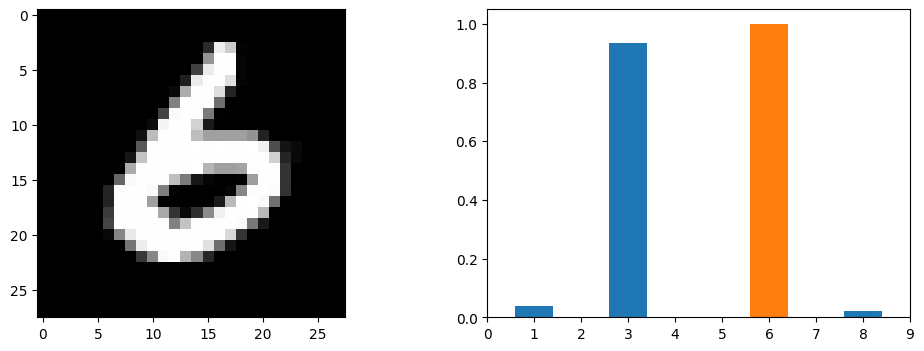

In [8]:
def predict_random_from_train(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_train))
        ax[0].imshow(x_train[n])
        y_sample = (net.forward(x_train[n].unsqueeze(0).unsqueeze(0))).squeeze()
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_train[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample


def predict_random_from_test(net: torch.nn.Module, apply_softmax=True): 
    with torch.no_grad():
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        n = random.randint(0, len(x_test))
        ax[0].imshow(x_test[n])
        y_sample = ((net.forward(x_test[n].unsqueeze(0).unsqueeze(0))).squeeze())
        y_sample = softmax(y_sample) if apply_softmax else y_sample 

        ax[1].bar(x=torch.arange(10), height=y_sample)
        ax[1].bar(x=y_test[n], height=1)

        ax[1].set_xlim(0, 9)
        
    return y_sample 

y_sample = predict_random_from_test(classifier, apply_softmax=True)
print(y_sample.tolist())

In [9]:
def predict(net: torch.nn.Module, x): 
    return net.forward(x.unsqueeze(1))

with torch.no_grad():
    print(softmax(predict(classifier, x_train).squeeze()))

tensor([[7.3478e-06, 9.5428e-06, 2.3882e-07,  ..., 3.2491e-06, 1.1274e-06,
         1.9898e-05],
        [7.6085e-06, 1.5314e-05, 3.6786e-09,  ..., 3.4622e-10, 4.2571e-10,
         5.6401e-06],
        [1.8246e-07, 4.9803e-09, 3.3564e-06,  ..., 7.2316e-09, 2.7883e-10,
         8.8635e-06],
        ...,
        [7.1262e-07, 7.6286e-06, 3.4187e-08,  ..., 1.1962e-07, 1.6645e-09,
         1.6736e-06],
        [2.5977e-07, 8.3034e-08, 1.2357e-06,  ..., 2.5632e-10, 7.0234e-11,
         1.3269e-04],
        [3.7624e-06, 2.3615e-06, 4.2577e-08,  ..., 5.8313e-11, 2.0248e-09,
         2.5920e-05]])


epoch 0, loss 0.26703264005482197
epoch 1, loss 0.09528300736565143
epoch 2, loss 0.07473399676382542
epoch 3, loss 0.06310081892297603
epoch 4, loss 0.054689813347067684
epoch 5, loss 0.049640078126685694
epoch 6, loss 0.04524373181629926
epoch 7, loss 0.0428380359953735
epoch 8, loss 0.04102592379786074
epoch 9, loss 0.03945247325464152


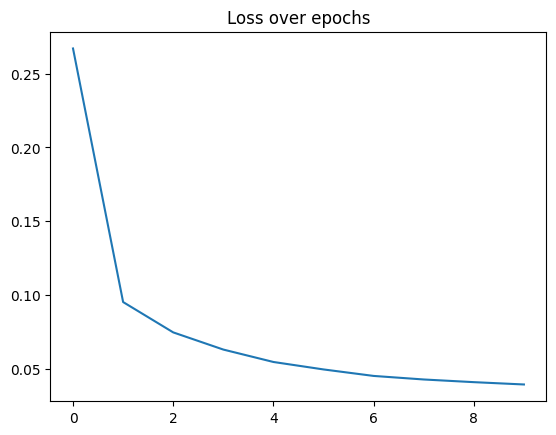

In [10]:
def fit(classifier, epochs=20, verbose=True):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-2)
    loss = nn.CrossEntropyLoss()

    history = []
    train_loader = DataLoader(dataset_train, batch_size=512, shuffle=True, num_workers=2)

    for epoch in range(0, epochs):
        epoch_loss = 0

        for x_batch, y_true_batch in train_loader:
            optimizer.zero_grad()
            logits = classifier.forward(x_batch)
            
            loss_val = loss(logits, y_true_batch)
            loss_val.backward()
            
            optimizer.step()
            epoch_loss += loss_val.item()

        epoch_loss /= train_loader.batch_size
        history.append(epoch_loss)

        if verbose:
            print(f'epoch {epoch}, loss {epoch_loss}')
    
    return history

history = fit(classifier, 10)

plt.title("Loss over epochs")
plt.plot(torch.arange(0, 10), history)

In [14]:
# Counting accuracy
def calculate_accuracy(classifier, x_test, y_test):
    with torch.no_grad():
        predicted = torch.argmax(classifier.forward(x_test.unsqueeze(1)), dim=1)
        accuracy = ((predicted == y_test).sum() / y_test.shape[0]).item()
    return accuracy
    
calculate_accuracy(classifier, x_test, y_test)

0.9584000110626221

In [12]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach().squeeze(0) # output.detach().clone().requires_grad_(True)
    return hook

classifier.pipeline[3].register_forward_hook(get_activation('conv2'))

0.9584000110626221

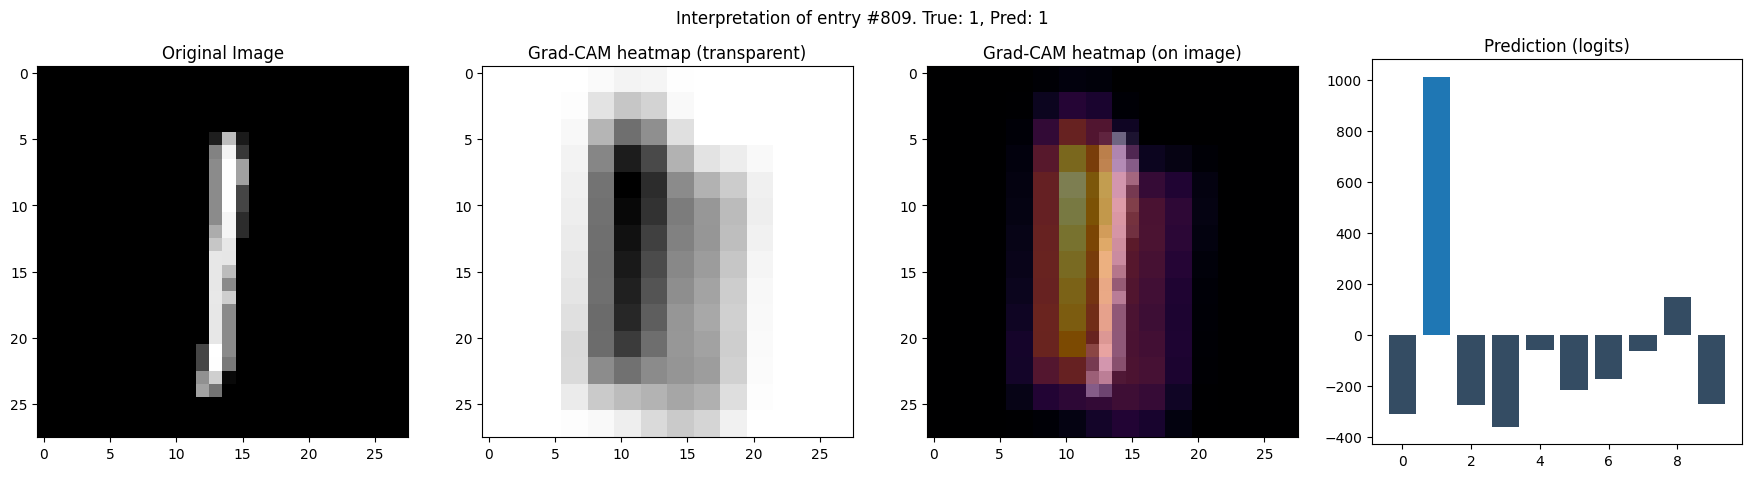

In [16]:
'''
    Here we've come up to the theoretical part
    Assuming Flatten() doesn't change gradients, we can get gradients of linear layer 
'''

def build_heatmap(net, image: Tensor, c=0):
    y = net.forward(image)
    y_c = y[0][c]
    y_c.backward()

    d_yc_d_linear = classifier.pipeline[-1].weight.grad[c]
    d_yc_d_Map = lambda k: d_yc_d_linear[16 * (k - 1) : 16 * k - 1]
    
    alpha_c = torch.zeros(16)
    heatmap = torch.zeros_like(activation['conv2'][0])
    for k in range(16):
        alpha_c[k] = d_yc_d_Map(k).mean()
        activation_map = activation['conv2'][k]
        heatmap += alpha_c[k].item() * activation_map

    return relu(heatmap).detach()

n = random.randint(0, len(x_test))
x_sample = x_test[n].unsqueeze(0).unsqueeze(0)
y_true_sample = y_test[n]
y_pred_sample_logits = classifier.forward(x_sample).detach().squeeze()
y_pred_sample = y_pred_sample_logits.argmax()
heatmap = build_heatmap(classifier, x_sample, c=y_true_sample)

fig, ax = plt.subplots(1, 4, figsize=(22, 5),)
x_sample = x_sample.squeeze(0).squeeze(0)

fig.suptitle(f'Interpretation of entry #{n}. True: {y_true_sample}, Pred: {y_pred_sample}')
ax[0].set_title("Original Image")
ax[0].imshow(x_sample.squeeze(0).squeeze(0))


ax[1].set_title("Grad-CAM heatmap (transparent)")
ax[1].imshow(-F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='nearest')[0][0])

ax[2].set_title("Grad-CAM heatmap (on image)")
scaled = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), scale_factor=2, mode='nearest')[0][0]
ax[2].imshow(x_sample)
ax[2].imshow(scaled, alpha=0.5, cmap='inferno')

ax[3].set_title("Prediction (logits)")
ax[3].bar(x=torch.arange(0, 10), height=y_pred_sample_logits, color=PLOT_COLOR_NEUTRAL)
ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_logits))

if y_pred_sample != y_true_sample:
    ax[3].bar(x=y_pred_sample, height=max(y_pred_sample_logits), width=1, color=PLOT_COLOR_BAD)
    ax[3].bar(x=y_true_sample, height=y_pred_sample_logits[y_true_sample], width=1, color=PLOT_COLOR_GOOD)


calculate_accuracy(classifier, x_test, y_test)